In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image as tfk_image

import shutil
import json

from skimage import io

from pathlib import Path
from sklearn.model_selection import train_test_split

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)
%matplotlib inline

In [2]:
DEFAULT_IMAGE_SIZE = 512

def read_data(path, float_key='images', scale_fctr=255., return_3D=False):
    # type enforcement for consistency
    try:
        if float_key in str(path):
            data = _read_float(path, scale_fctr)
        else:
            data = _read_u8(path, scale_fctr)
        if return_3D:
            data = np.atleast_3d(data)
        return data
    except Exception as e:
        print(f'Exception occurred reading file {Path(path)}')
        raise e

def _read_float(path, scale_fctr=1.):
    x = io.imread(path) / scale_fctr
    return x.astype('float32') 

def _read_u8(path, scale_fctr=1):
    x = io.imread(path) / scale_fctr
    return x.astype('uint8')

In [3]:
def compute_boundary(src_path_series, num_cycles=1, glob_str = '*.png'):
    """helper to generate eroded boundary class"""
    import skimage.morphology as morph

    # loop over each path in the dir, 
    for src_path in Path(src_path_series[0]).glob(glob_str):
        # load data, dilate class to generate boundary
        data = read_data(src_path, scale_fctr=1)
        data_dilate = data.copy()
        for i in range(num_cycles):
            data_dilate = morph.dilation(data_dilate, morph.diamond(1))
        data = data_dilate - data
        io.imsave(src_path, data, check_contrast=False)    

        
def compute_background(src_path_series, num_cycles=1, glob_str = '*.png'):
    """helper to generate background after eroding base and boundary class"""
    import skimage.morphology as morph
    
    # loop over each path in the dir, 
    for src_path in Path(src_path_series[0]).glob(glob_str):
        # load data, dilate class to generate boundary
        data = read_data(src_path, scale_fctr=1)
        data_dilate = data.copy()
        for i in range(num_cycles):
            data_dilate = morph.dilation(data_dilate, morph.diamond(1))

        # define background class (ones x data_max), erode building and boundary
        data = np.ones_like(data)*data.max() - data - data_dilate
        io.imsave(src_path, data, check_contrast=False)

        
################################

        
def validate_make_dirpath(base_path: str, sub_dir: str) -> Path:
    """Helper method to create a directory path and verify existence"""
    out_path = Path(base_path) / sub_dir
    if not out_path.is_dir():
        out_path.mkdir()
    return out_path


def df_copy_update_dataset(dataset_df, dataset_path, src_key, dst_type, class_dir=None):
    """method for dataframe apply - copy images to 'type' sub-dir, with optional
       class sub-sub dir"""
    
    # update dataframe with dst_type dir path (e.g. .../datasets/train/<type, e.g. images>) & validate
    dst_dir = validate_make_dirpath(dataset_path, dst_type)

    # append class if supplied, copy files
    if class_dir is not None:
        # update dst_dir path with class & validate
        # (e.g. .../datasets/train/images/<class, e.g. buildings>) 
        dst_dir = validate_make_dirpath(dst_dir, class_dir)
    
    # copy all images over
    for src_path in dataset_df[src_key]:
        src_path = Path(src_path)
        shutil.copy(src_path, dst_dir / src_path.name)
    
    # update with final dir name and return if desired
    dataset_df[dst_dir.name] = str(dst_dir)
    return dataset_df


# dict of callables mapping to generation of class labels
# add additional or None if no callable 
DEFAULT_CLASS_CALLABLE_DICT = {'building': None, 'boundary': compute_boundary, 'background': compute_background}


# set up basic loader to parse and split data
def validate_split_data(dataframe, test_split=0.15, valid_split=0.15, rand_seed=42,
                        img_col='local_image', msk_col='local_mask',  img_dir='images', msk_dir='masks',
                        dataset_dir='datasets_new', train_dir='train', valid_dir='valid', test_dir='test',
                        class_dir_dict = DEFAULT_CLASS_CALLABLE_DICT):
    # compute train, test and validation sizes
    total_size = len(dataframe)
    valid_size = int(valid_split * total_size)
    test_size = int(test_split * total_size)
    
    # split into datasets
    train_df, test_df = train_test_split(dataframe, test_size=test_size, random_state=rand_seed)
    train_df, valid_df = train_test_split(train_df, test_size=valid_size, random_state=rand_seed)
    
    # need to generate class folders (image, class_dir)
    # parent-data dir, create dataset_dir
    parent_dir = Path(dataframe[img_col][0]).parent.parent
    dataset_path = validate_make_dirpath(parent_dir, dataset_dir)
    
    # create lists of dataframes and directories
    df_list, df_dir_list = [], []
    for df, sub_dir in zip([train_df, valid_df, test_df], 
                           [train_dir, valid_dir, test_dir]):
        # if label defined, append to lists
        if sub_dir is not None:
            df_dir = validate_make_dirpath(dataset_path, sub_dir)
            df_dir_list.append(df_dir)
            df_list.append(df)
    
    # create explicit class mask types and duplicate source images
    final_df_list = []
    for df, df_dir in zip(df_list, df_dir_list):
        for cls_lbl, cls_call in class_dir_dict.items():
            # copy image source files in case, copy-create paths for 
            df_copy_update_dataset(df, df_dir, img_col, img_dir, cls_lbl)
            df = df_copy_update_dataset(df, df_dir, msk_col, msk_dir, cls_lbl)
            
            # apply callable to modify class mask labels in place
            if cls_call is not None:
                cls_call(df[cls_lbl].to_list())
        
        # append df to the return list
        final_df_list.append(df)
    return final_df_list
   

#### Overview
Let's make sure we understand what our desired augmentation steps are going to be doing before we launch into a model training section. In order to do that, we need to set up a few things first...
1. Set up a splitter to grab the datasets and return train, test and validation sets
2. Build an image reader method to handle loading the data from the image and mask
3. Test out augmentations individually to validate that each individual augmentation is performing as expected
4. Put it all together and make sure the pipeline behaves as intended

In [4]:
# open cleaned dataframe, will be used in flow_from_dataframe
base_dir = Path('C:/Users/NPDan/Documents/GitHub/task_challenge/data')
json_path = base_dir / 'data_local_clean.json'
url_local_clean = pd.read_json(json_path)
url_local_clean.head()

,mask_url,image_url,local_image,local_mask
0,https://d1h90vpqo1860x.cloudfront.net/ab53069c...,https://d1h90vpqo1860x.cloudfront.net/3e18e6da...,C:\Users\NPDan\Documents\GitHub\task_challenge...,C:\Users\NPDan\Documents\GitHub\task_challenge...
1,https://d1h90vpqo1860x.cloudfront.net/8728de7a...,https://d1h90vpqo1860x.cloudfront.net/5daefb3e...,C:\Users\NPDan\Documents\GitHub\task_challenge...,C:\Users\NPDan\Documents\GitHub\task_challenge...
2,https://d1h90vpqo1860x.cloudfront.net/baa75595...,https://d1h90vpqo1860x.cloudfront.net/74217c21...,C:\Users\NPDan\Documents\GitHub\task_challenge...,C:\Users\NPDan\Documents\GitHub\task_challenge...
3,https://d1h90vpqo1860x.cloudfront.net/2e1508f0...,https://d1h90vpqo1860x.cloudfront.net/eeb2ed67...,C:\Users\NPDan\Documents\GitHub\task_challenge...,C:\Users\NPDan\Documents\GitHub\task_challenge...
4,https://d1h90vpqo1860x.cloudfront.net/2b42cbd4...,https://d1h90vpqo1860x.cloudfront.net/ba7e2239...,C:\Users\NPDan\Documents\GitHub\task_challenge...,C:\Users\NPDan\Documents\GitHub\task_challenge...


In [5]:
# get training, validation and test sets
train_df, valid_df, test_df = validate_split_data(url_local_clean)

<ipython-input-3-1fb1702b5137>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_df[dst_dir.name] = str(dst_dir)


At this point, the frames look split successfully and the data should be copied to the correct file structures

Let's now set up a quick visualizer

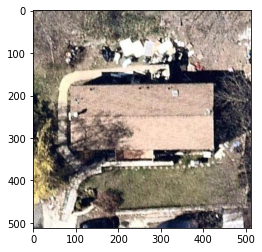

((512, 512, 3), dtype('float32'), 0.0, 1.0)

In [6]:
x_col, y_col = 'local_image', 'local_mask'
image = read_data(train_df[x_col][0])
plt.imshow(image)
plt.show()
image.shape, image.dtype, image.flatten().min(), image.flatten().max()

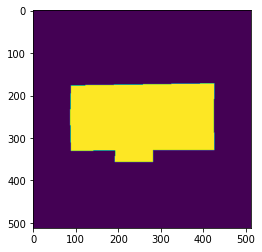

((512, 512), dtype('uint8'), 0, 1)

In [7]:
mask = read_data(train_df[y_col][0])
plt.imshow(mask)
plt.show()
mask.shape, mask.dtype, mask.flatten().min(), mask.flatten().max()

Awesome, that looks sexy. First, let's make sure we can visualize changes, then let's start testing some augmentation steps.

In [8]:
def visualize_augment_and_mask(img_original, img_augmented, msk_original=None, msk_augmented=None,
                               mask_cmap_name='winter', show_axis=True, title_prefix = ''):
    # plot original
    fig = plt.figure()
    plt.subplot(1,2,1)
    if msk_original is not None:
        # overlay mask if applicable
        msk_original = msk_original.squeeze()
        plt.title(' '.join((title_prefix, 'Original + Mask')))
        plt.imshow(img_original, vmin=0, vmax=1)
        plt.imshow(msk_original, alpha=0.4*msk_original, vmin=0, vmax=1,
                   cmap=plt.get_cmap(mask_cmap_name))
    else:
        plt.title(' '.join((title_prefix, 'Original')))
        plt.imshow(img_original)
    if not show_axis:
        plt.axis('off')
        
    # plot augmented
    plt.subplot(1,2,2)
    if msk_augmented is not None:
        # overlay mask if applicable
        msk_augmented = msk_augmented.squeeze()
        plt.title(' '.join((title_prefix, 'Augmented + Mask')))
        plt.imshow(img_augmented, vmin=0, vmax=1)
        plt.imshow(msk_augmented, alpha=0.4*msk_augmented.squeeze(), vmin=0, vmax=1,
                   cmap=plt.get_cmap(mask_cmap_name))
    else:
        plt.title(' '.join((title_prefix, 'Augmented')))
        plt.imshow(img_augmented)
    if not show_axis:
        plt.axis('off')
    plt.show()


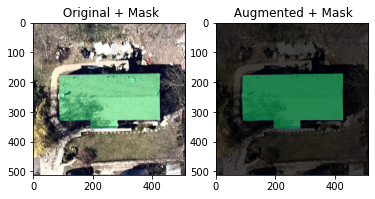

In [9]:
# let's test that out
visualize_augment_and_mask(image, image*0.25, mask, mask, show_axis=True)

Looking good! Let's try out a basic data augmentation pipeline and see the results

In [10]:
train_df.columns

Index(['mask_url', 'image_url', 'local_image', 'local_mask', 'building',
       'boundary', 'background'],
      dtype='object')

In [5]:
# taken from https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

# define datagenerator args
translate_fctr, zoom_fctr, rotate_range = 0.05, 0.05, 5 # rotation in degrees
brightness_rng, rescale_fctr, ch_shift_rng = (0.8, 1.1), 1/255., 48 # ch shift value in u8 range due to pre-rescale
flip_lr, flip_ud, fill_mode, data_ch_fmt = True, True, 'reflect', 'channels_last'

# store in dicts for image and mask generator
imggen_args = dict(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False,
                   samplewise_std_normalization=False, zca_whitening=False,  fill_mode=fill_mode,
                   rotation_range=rotate_range, width_shift_range=translate_fctr, height_shift_range=translate_fctr,
                   zoom_range=zoom_fctr, brightness_range=brightness_rng, channel_shift_range=ch_shift_rng,
                   horizontal_flip=flip_lr, vertical_flip=flip_ud, data_format=data_ch_fmt, rescale=rescale_fctr)
mskgen_args = dict(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False,
                   samplewise_std_normalization=False, zca_whitening=False,  fill_mode=fill_mode,
                   rotation_range=rotate_range, width_shift_range=translate_fctr, height_shift_range=translate_fctr,
                   zoom_range=zoom_fctr, brightness_range=None, rescale=rescale_fctr,
                   horizontal_flip=flip_lr, vertical_flip=flip_ud, data_format=data_ch_fmt)

# NOTE: if this doesn't work, we can write a quick preprocessing function to handle augmentation
#       Good use case of partial 

# instantiate both with args, they **SHOULD** preserve the augmentations since they were seeded the same
img_datagen = tfk_image.ImageDataGenerator(**imggen_args)
msk_datagen = tfk_image.ImageDataGenerator(**mskgen_args)

In [12]:
Path(train_df['building'].unique()[0].replace('masks','images'))

WindowsPath('C:/Users/NPDan/Documents/GitHub/task_challenge/data/datasets_new/train/images/building')

Found 504 images belonging to 3 classes.
Found 504 images belonging to 3 classes.


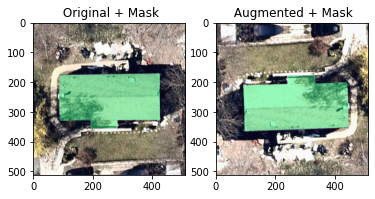

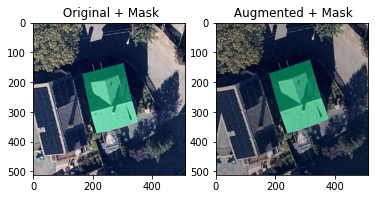

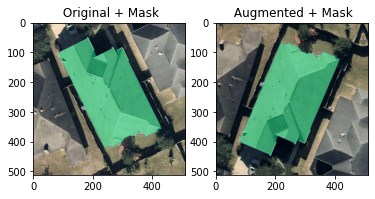

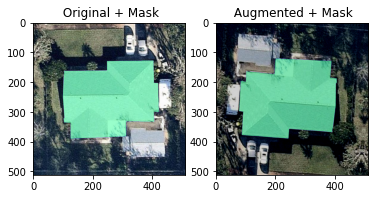

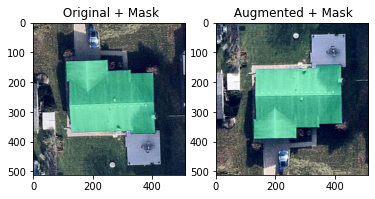

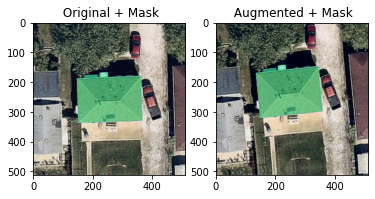

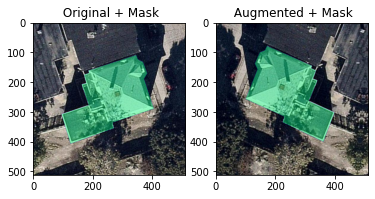

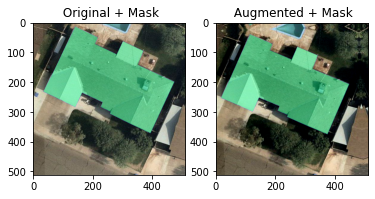

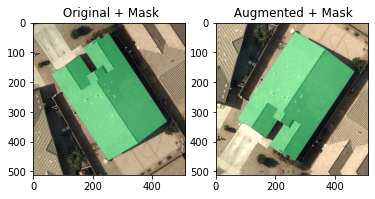

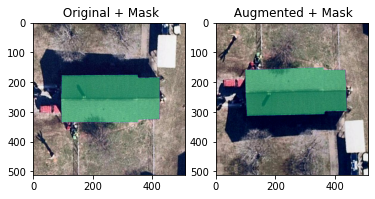

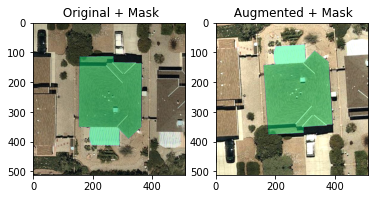

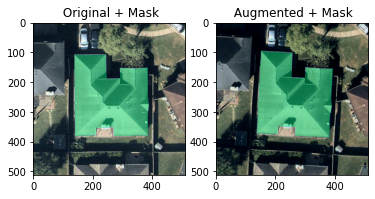

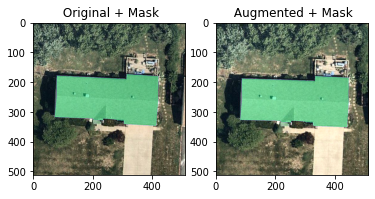

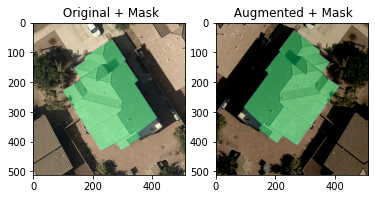

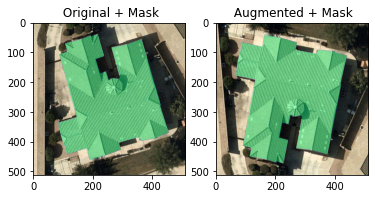

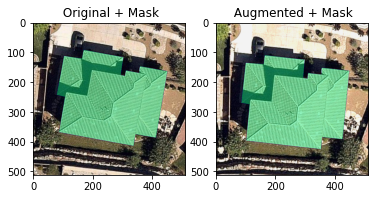

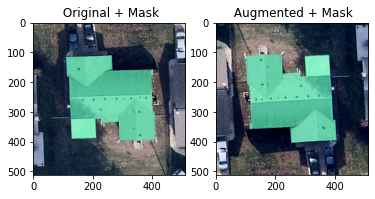

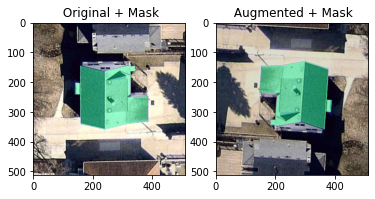

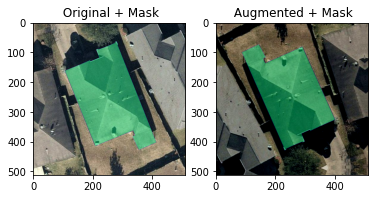

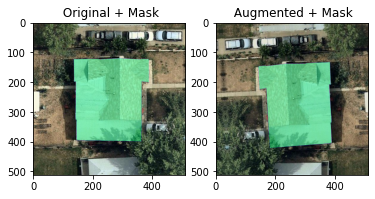

In [13]:
# define seed and batch size
gen_seed, flow_seed, batch_size, aug_rounds = 7, 42, 1, 3
class_mode, img_size, class_names= None, (512, 512), ['building', 'boundary', 'background']

# fit and set flow using same args
# img_datagen.fit([read_data(fp) for fp in original_imgs], seed=gen_seed, rounds=aug_rounds)
# msk_datagen.fit([read_data(fp, return_3D=True) for fp in original_msks], seed=gen_seed, rounds=aug_rounds)
# datagen.fit(train_imgs, seed=gen_seed, rounds=aug_rounds)
            
# test flow
# img, msk, (img_aug, msk_aug) = \
#     next(zip(train_imgs, train_msks, img_datagen.flow(train_imgs), msk_datagen.flow(train_msks)))

img_dir = Path(train_df['building'].unique()[0].replace('masks','images')).parent
msk_dir = Path(train_df['building'].unique()[0]).parent
img_generator = img_datagen.flow_from_directory(img_dir, seed=flow_seed, shuffle=False, batch_size=batch_size,
                                                color_mode='rgb', class_mode=class_mode, target_size=img_size,
                                                classes=class_names)
msk_generator = msk_datagen.flow_from_directory(msk_dir, seed=flow_seed, shuffle=False, batch_size=batch_size,
                                                color_mode='grayscale', class_mode=class_mode, target_size=img_size,
                                                classes=class_names)
train_generator = zip(img_generator, msk_generator)

original_imgs = sorted((img_dir / class_names[0]).glob('*.png'))
original_msks = sorted((msk_dir / class_names[0]).glob('*.png'))

# test consistency of augments and display
for ii, (img_aug, msk_aug) in enumerate(train_generator):
    if ii < 20:
        img = read_data(original_imgs[ii])
        msk = read_data(original_msks[ii])
        img_aug = img_aug.flatten().reshape(img_size + (3,))
        msk_aug = msk_aug.flatten().reshape(img_size + (1,))
        visualize_augment_and_mask(img, img_aug,msk, msk_aug, show_axis=True)
    else:
        break

### Lord have mercy...
Finally got it working. Very good.

I also did a quick test of the `shuffle` parameter and it does appear to change the augment applied with each iteration of the training image. That's great as we don't need to mess with things manually. 

#### Test & Validation Augmentation
I'd like to augment the test and validation data, but I *don't* want to introduce randomness each iteration through the  validation set by not knowing which augmentations apply. So let's apply some flips (L/R & U/D) and rotates (+- pi/2) to each image in the set and store the result, effectively increasing the dataset size x4.

#### Next Steps
1. loop through the validation and test sets, save the flipped/rotated versions of the images and update the df with those columns indicating the augs applied to each image
2. Save all the dataframes as JSONs in the `data` folder.
3. Save the argument dicts for the image generators as jsons in the folder as well


At that point, I think we'll have everything we need to train a proper model. We can first verify if the model can memorize the non-augmented images and then advance to actually training the 

In [14]:
def _augment_img_msk(path_tuple: tuple, aug_method: callable, aug_suffix: str, kwargs=dict()) -> bool:
    """helper to handle augmentation and writing of images, callable returns equiv np array"""
    # loop through tuples, apply augmentation, store result
    for path in path_tuple:
        img = io.imread(path)
        imgA = aug_method(img, **kwargs)
        stem, suffix = path.stem, path.suffix
        pathA = path.parent / ('_'.join((stem, aug_suffix)) + suffix)
        io.imsave(pathA, imgA)
    
    return True
        
        
def manually_augment_dataset(dataframe: pd.DataFrame, flip_lr:bool=True, flip_ud:bool=True,
                             rotate_cw:bool=True, rotate_ccw:bool=True, img_key:str='images',
                             msk_key:str='masks', class_key:str='building', img_ftype:str='png') -> None:
    """
    Helper method to manually augment dataset (e.g. valid_df) by applying flips, rotations, writing
    out resultant images and updating dataframe
    """
    # set up paths to image and mask folders
    img_class_path = Path(dataframe[class_key].unique()[0].replace('masks','images'))
    msk_class_path = Path(dataframe[class_key].unique()[0])
    
    # get list of images in each, verify length
    img_list = sorted(img_class_path.glob('.'.join(('*',img_ftype))))
    msk_list = sorted(msk_class_path.glob('.'.join(('*',img_ftype))))
    if not len(img_list) == len(msk_list):
        print(f'Variable file counts found between {img_class_path} & {msk_class_path}, aborting.')
        return None
    
    # loop through images, apply augments
    for path_tuple in zip(img_list, msk_list):
        if flip_lr:
            dataframe['flip_lr'] = _augment_img_msk(path_tuple, np.fliplr, 'lr')
        if flip_ud:
            dataframe['flip_ud'] = _augment_img_msk(path_tuple, np.flipud, 'ud')
        if rotate_ccw:
            dataframe['rot_ccw'] = _augment_img_msk(path_tuple, np.rot90, 'ccw', {'k': 1})
        if rotate_cw:
            dataframe['rot_cw'] = _augment_img_msk(path_tuple, np.rot90, 'cw', {'k': 3})
    return dataframe  

In [15]:
# now let's write those augmented images and save the dfs
for class_key in class_names:
    valid_df = manually_augment_dataset(valid_df, class_key=class_key)
    test_df = manually_augment_dataset(test_df, class_key=class_key)
train_df.to_json(base_dir / 'train_df.json')
valid_df.to_json(base_dir / 'valid_df.json')
test_df.to_json(base_dir / 'test_df.json')

<ipython-input-14-6d125033fa42>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['flip_lr'] = _augment_img_msk(path_tuple, np.fliplr, 'lr')
<ipython-input-14-6d125033fa42>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['flip_ud'] = _augment_img_msk(path_tuple, np.flipud, 'ud')
<ipython-input-14-6d125033fa42>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_003_lr_ccw.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_003_lr_cw.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_003_ud_lr.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_003_ud_ud.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_003_ud_ccw.png is a low contrast image
  io.imsave(pathA,

<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_027_ud_lr.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_027_ud_ud.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_027_ud_ccw.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_027_ud_cw.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_038_lr.png is a low contrast image
  io.imsave(pathA, img

<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_054_ud_ccw.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_054_ud_cw.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_059_lr.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_059_ud.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_059_ccw.png is a low contrast image
  io.imsave(pathA, imgA)
<i

<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_062_lr.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_062_ud.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_062_ccw.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_062_cw.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_062_ccw_lr.png is a low contrast image
  io.imsave(pathA, imgA)
<ipyt

<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_075_ud.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_075_ccw.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_075_cw.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_075_ccw_lr.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_075_ccw_ud.png is a low contrast image
  io.imsave(pathA, imgA)
<

<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_085_cw.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_085_ccw_lr.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_085_ccw_ud.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_085_ccw_ccw.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_085_ccw_cw.png is a low contrast image
  io.imsave(pathA,

<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_093_ccw_ud.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_093_ccw_ccw.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_093_ccw_cw.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_093_cw_lr.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_093_cw_ud.png is a low contrast image
  io.imsave(path

<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_117_ccw_ccw.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_117_ccw_cw.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_117_cw_lr.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_117_cw_ud.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_117_cw_ccw.png is a low contrast image
  io.imsave(path

<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_130_cw_lr.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_130_cw_ud.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_130_cw_ccw.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_130_cw_cw.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_130_lr_lr.png is a low contrast image
  io.imsave(pathA, 

<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_134_cw_ccw.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_134_cw_cw.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_134_lr_lr.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_134_lr_ud.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_134_lr_ccw.png is a low contrast image
  io.imsave(pathA,

<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_148_cw_cw.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_148_lr_lr.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_148_lr_ud.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_148_lr_ccw.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_148_lr_cw.png is a low contrast image
  io.imsave(pathA, 

<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_161_lr_ud.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_161_lr_ccw.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_161_lr_cw.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_161_ud_lr.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_161_ud_ud.png is a low contrast image
  io.imsave(pathA, 

<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_191_lr_cw.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_191_ud_lr.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_191_ud_ud.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_191_ud_ccw.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_191_ud_cw.png is a low contrast image
  io.imsave(pathA, 

<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_196_ud_ud.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_196_ud_ccw.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_196_ud_cw.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_201_lr.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_201_ud.png is a low contrast image
  io.imsave(pathA, imgA)


<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_202_ud_ccw.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_202_ud_cw.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_215_lr.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_215_ud.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_215_ccw.png is a low contrast image
  io.imsave(pathA, imgA)
<i

<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_231_ud_cw.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_232_lr.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_232_ud.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_232_ccw.png is a low contrast image
  io.imsave(pathA, imgA)
<ipython-input-14-6d125033fa42>:9: UserWarning: C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\valid\masks\boundary\img_232_cw.png is a low contrast image
  io.imsave(pathA, imgA)
<ipyth

Variable file counts found between C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\test\images\boundary & C:\Users\NPDan\Documents\GitHub\task_challenge\data\datasets_new\test\masks\boundary, aborting.


TypeError: 'NoneType' object is not subscriptable

In [7]:
# let's save the augmention dicts for reference also
img_gen_path = base_dir / 'image_generator_args.json'
with open(img_gen_path, 'w') as fp:
    json.dump(imggen_args, fp)

msk_gen_path = base_dir / 'mask_generator_args.json'
with open(msk_gen_path, 'w') as fp:
    json.dump(mskgen_args, fp)   
    

# Done with that!!! Now, once more into the breach...